<a href="https://colab.research.google.com/github/Hamedamz/fls-localization/blob/main/notebooks/FLSLocalization_1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from math import sqrt
import random
import matplotlib.pyplot as plt
import numpy as np
from time import sleep

In [ ]:
point_cloud_1 = {(10,)}
point_cloud_2 = {(10,), (11,)}
point_cloud_3 = {(10,), (12,)}
point_cloud_4 = {(10,), (11,), (12,)}
point_cloud_5 = {(10,), (11,), (13,)}
point_cloud_6 = {(10,), (11,), (12,), (13,)}
point_cloud_7 = {(10,), (11,), (13,), (14,)}

In [ ]:
screen = {}
display_cell_size = 1
_V = True

# Utils

In [ ]:
def get_coord_id(coord):
  return'.'.join(map(str, coord))

In [ ]:
def get_distance(coord_1, coord_2):
  delta = [coord_1[i] - coord_2[i] for i in range(len(coord_1))]
  return sqrt(sum([d**2 for d in delta]))

# Step 1

FLS estimates its display cell relative to the coordinates of its dispatcher and flight trajectory.

How?
Pick a random angle once at the start at the dispatcher:
* Pick a circle with a fixed radius centered on the destination at the trajectory of the straight line from the dispatcher
* Select a random point in the circle
* Travel from the dispatcher to the random point using the distance to the real destination. 

Notes:
* Accuracy is dependent on the radius of the circle.
* Radius r can be a function of distance

In [ ]:
dispatcher_error_percent = 5 #@param {type:"slider", min:0, max:100, step:1}
dispatcher_location = (0, 0, 0)

In [ ]:
def get_error_radius(distance):
  return dispatcher_error_percent * distance / 100.0

In [ ]:
def dispatch(point_cloud, error_function=get_error_radius, dispatcher_location=dispatcher_location):
  global screen

  screen.clear()
  for i, point in enumerate(point_cloud):
    distance = get_distance(point, dispatcher_location)
    e = error_function(distance)
    id = get_coord_id(point)
    fls = {
        "id": id,
        "el": (distance + random.uniform(-e, e),),
        "gtl": point,
    }
    screen[id] = fls


In [ ]:
def show_plot(screen, show_gtl=True):
  fig, ax = plt.subplots()

  if show_gtl:
    points = [fls["gtl"] for fls in screen.values()]
    px = [p[0] for p in points]
    py = [0 for p in points]
    ax.scatter(px, py, label="ground truth")


  points = [fls["el"] for fls in screen.values()]
  x = [p[0] for p in points]
  y = [0 for p in points]

  ax.scatter(x, y, label="estimated")
  ax.set(xlim=(8, 15))

  plt.legend()
  plt.grid()
  plt.show()

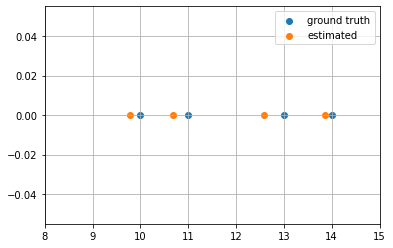

In [ ]:
dispatch(point_cloud_7)
show_plot(screen, point_cloud_7)

# Step 2

Assume that an FLS may communicate with a fixed number of display cells away. Receiving FLSs respond back sending their ground truch location with some confidence in their location.

**Definitions:**
* A **communication sphere** has a radius equal to the distance from the display cell to the farthest corner cube.
* We use the ground truth location (**GTL**)  for where the FLS must be positioned. 
* We use estimated location (**EL**) for the current location of an FLS.  

**Assumptions:**
* The dispatcher/orchestrator tells the FLS **when** its neighbors will arrive.



## Case 1

An FLS might be inside the GTL communication sphere and not communicate with its neighboring FLSs.

**Possible sources of error:** Packet loss (ignored for now), outside the range because of the error introduced by the EL sphere (with no packet loss), the neighboring FLS has either not arrived yet or not dispatched yet.



---


Why is Case 1 important to consider? 

The requesting FLS may be farther than it should be from the FLS that is inside the GTL cube and has not responded.


---

What happens in Case 1?

The FLS should adjust its location to get closer to the missing neighboring FLSs that should be inside the GTL sphere.  The neighboring FLSs may not be inside the GTL because they are also estimating their location.  

How?
* When error as a function of distance is known then explore the surface of a sphere to find the correct location. Keep track of the actions taken to handle other cases.
* When the error function is unknown explore the surface of a sphere with radius as a function of the display cell, select a radius based on messages received from neighboring FLSs (see interaction of Case 1 with 2). 



In [ ]:
glt_dxs = [
    [-1, 1],
    [-1, 0, 1, 1, 1, 0, -1, -1],
]

glt_dys = [
    [0, 0],
    [-1, -1, -1, 0, 1, 1, 1, 0],
]

def get_gtl_neighbors(id):
  if not id in screen:
    return {}

  fls = screen[id]

  neighbors = {}

  for dx in glt_dxs[0]:
    neighbor_id = get_coord_id((fls["gtl"][0] + dx,))

    if neighbor_id in screen:
      neighbors[neighbor_id] = screen[neighbor_id]

  return neighbors


In [ ]:
el_dxs = [
    [-1, 1],
    [-1, 0, 1, 1, 1, 0, -1, -1],
]

el_dys = [
    [0, 0],
    [-1, -1, -1, 0, 1, 1, 1, 0],
]

def get_el_neighbors(id):
  if not id in screen:
    return {}

  fls = screen[id]

  neighbors = {}

  for dx in el_dxs[0]:
    neighbor_id = get_coord_id((fls["gtl"][0] + dx,))

    if neighbor_id in screen:
      neighbor = screen[neighbor_id]
      distance = get_distance(fls["el"], neighbor["el"])
      if distance <= display_cell_size:
        neighbors[neighbor_id] = screen[neighbor_id]

  return neighbors

In [ ]:
def get_expected_neighbors(id):
  gtl_neighbors = get_gtl_neighbors(id)
  el_neighbors = get_el_neighbors(id)

  expected_neighbors = set(gtl_neighbors) - set(el_neighbors)

  if _V and len(expected_neighbors):
    print(f"FLS {id} expects {expected_neighbors} to be its neighbor.") 

  return expected_neighbors

In [ ]:
def get_unexpected_neighbors(id):
  gtl_neighbors = get_gtl_neighbors(id)
  el_neighbors = get_el_neighbors(id)

  unexpected_neighbors = set(el_neighbors) - set(gtl_neighbors)

  if _V and len(unexpected_neighbors):
    print(f"FLS {id} dosn't expect {unexpected_neighbors} to be its neighbor.") 

  return unexpected_neighbors

In [ ]:
screen

{'10': {'id': '10', 'el': (9.782188232650604,), 'gtl': (10,)},
 '13': {'id': '13', 'el': (12.587884736811075,), 'gtl': (13,)},
 '11': {'id': '11', 'el': (10.682975468814549,), 'gtl': (11,)},
 '14': {'id': '14', 'el': (13.863053707278652,), 'gtl': (14,)}}

Initial positions:


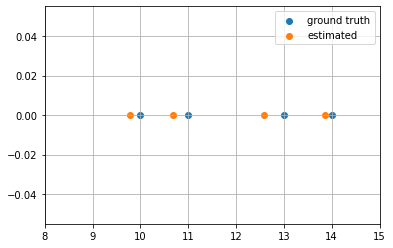

FLS 13 expects {'14'} to be its neighbor.
FLS 13 is adjusting.
FLS 14 expects {'13'} to be its neighbor.
FLS 14 is waiting.


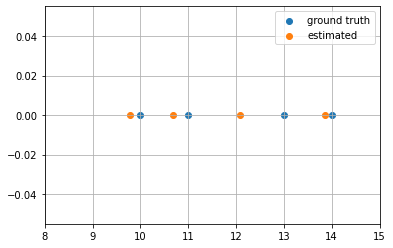

FLS 13 expects {'14'} to be its neighbor.
FLS 14 expects {'13'} to be its neighbor.
FLS 14 is waiting.


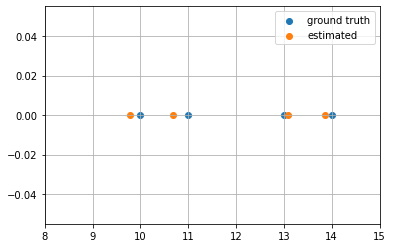

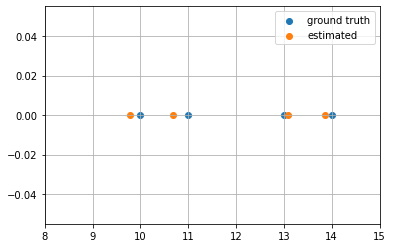

In [ ]:
adjusting_flss = {}
print("Initial positions:")
show_plot(screen)

while True:
  for id, fls in screen.items():
    expected_neighbors = get_expected_neighbors(id)
    # unexpected_neighbors = get_unexpected_neighbors(id)

    faults = len(expected_neighbors);

    if id in adjusting_flss:
      if faults < adjusting_flss[id]["faults"]:
        adjusting_flss[id]["best_location"] = fls["el"]
    elif faults:
      if id < min(expected_neighbors):
        adjusting_flss[id] = {
            "path": [(fls["el"][0] + 0.5,), (fls["el"][0] - 0.5,)],
            "best_location": fls["el"],
            "faults": len(expected_neighbors)
        }

        if _V:
          print(f"FLS {id} is adjusting.")

      elif _V:
          print(f"FLS {id} is waiting.")

  if len(adjusting_flss):
    for id in list(adjusting_flss.keys()):
      if len(adjusting_flss[id]["path"]):
        screen[id]["el"] = adjusting_flss[id]["path"].pop()
      else:
        screen[id]["el"] = adjusting_flss[id]["best_location"]
        del adjusting_flss[id]

  show_plot(screen)

  if not len(adjusting_flss):
    break
  


In [ ]:
screen

{'10': {'id': '10', 'el': (9.782188232650604,), 'gtl': (10,)},
 '13': {'id': '13', 'el': (13.087884736811075,), 'gtl': (13,)},
 '11': {'id': '11', 'el': (10.682975468814549,), 'gtl': (11,)},
 '14': {'id': '14', 'el': (13.863053707278652,), 'gtl': (14,)}}